In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import f_classif,SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib

import mlflow
import mlflow.sklearn

import warnings
warnings.simplefilter("always", category=UserWarning)

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# EDA

In [3]:
df.shape

(4240, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [5]:
# find missig values
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
# figure out what percentage of data will be remain if we remove these null values
(len(df.dropna())/len(df))*100

86.27358490566037

In [7]:
# 86 percent data will be remain if we remove nan values.
# we can take this step.
# as we will have enough data to train the model
df = df.dropna(axis=0)

In [8]:
# see sample after drop nan values
df.sample(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4103,0,51,2.0,0,0.0,0.0,0,1,0,238.0,123.0,80.0,22.19,80.0,100.0,0
650,0,58,3.0,1,20.0,0.0,0,0,0,281.0,134.0,81.0,22.54,58.0,74.0,0
2274,1,44,1.0,1,20.0,0.0,0,0,0,193.0,134.0,88.0,23.77,75.0,77.0,0
958,1,38,2.0,0,0.0,0.0,0,0,0,209.0,137.0,82.5,26.69,62.0,84.0,0
424,0,38,2.0,1,15.0,0.0,0,0,0,176.0,110.0,80.0,24.03,100.0,113.0,0
1320,0,57,2.0,0,0.0,0.0,0,0,0,239.0,127.0,81.0,21.85,75.0,87.0,0
2019,0,43,4.0,0,0.0,0.0,0,1,0,240.0,141.5,93.0,38.43,72.0,77.0,0
2877,1,49,2.0,1,20.0,0.0,0,1,0,291.0,160.0,99.0,29.91,85.0,88.0,0
3726,0,56,3.0,1,1.0,0.0,0,1,0,260.0,120.0,84.0,36.18,80.0,76.0,0
1271,0,54,1.0,0,0.0,0.0,0,0,0,272.0,146.0,95.0,23.66,72.0,80.0,0


In [9]:
# dropping education column
# there's nothing to deal with this column
df = df.drop('education', axis=1)

In [11]:
df.sample(10)

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
891,1,35,0,0.0,0.0,0,0,0,290.0,108.0,72.0,22.91,55.0,84.0,0
3121,0,38,1,15.0,0.0,0,1,0,267.0,179.5,97.0,20.44,76.0,67.0,0
4100,1,69,1,1.0,0.0,0,0,0,245.0,123.0,77.0,26.58,70.0,81.0,1
3879,1,40,1,40.0,0.0,0,0,0,334.0,120.0,77.0,22.66,82.0,92.0,0
3329,1,65,1,3.0,0.0,0,0,0,194.0,122.0,68.0,26.08,60.0,73.0,0
2443,1,66,0,0.0,0.0,0,1,0,124.0,138.0,91.0,32.33,75.0,96.0,1
1371,0,55,0,0.0,0.0,0,1,0,340.0,140.0,83.0,26.18,75.0,83.0,0
1518,0,47,1,9.0,0.0,0,1,0,253.0,129.0,81.0,22.18,70.0,122.0,1
78,0,45,0,0.0,0.0,0,1,0,183.0,151.0,101.0,45.80,80.0,63.0,0
1667,0,56,1,3.0,0.0,0,1,0,285.0,145.0,100.0,30.14,80.0,86.0,0


In [16]:
df.describe()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.443685,49.551941,0.489065,9.025424,0.030344,0.005741,0.311646,0.027064,236.847731,132.370558,82.917031,25.782802,75.730727,81.852925,0.152269
std,0.496886,8.562029,0.499949,11.921590,0.171557,0.075561,0.463229,0.162292,44.097681,22.086866,11.974258,4.065601,11.981525,23.904164,0.359331
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.875000,90.000000,28.037500,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


# visualization

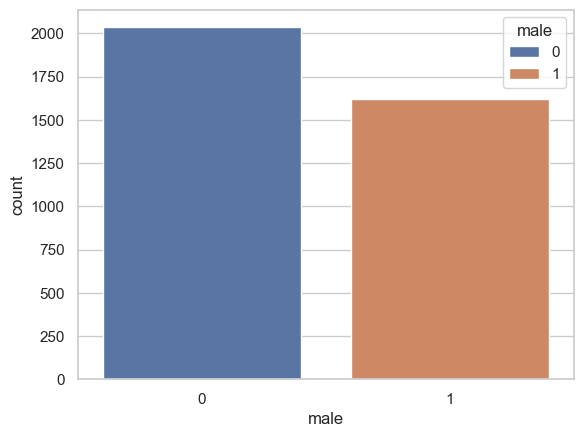

In [20]:
# count number of males(1)
sns.countplot(data=df, x='male', hue='male')
plt.show()

<Axes: xlabel='age', ylabel='Count'>

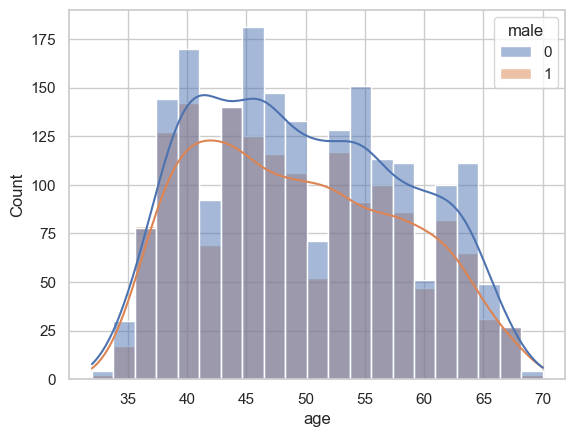

In [23]:
# distribution of age
sns.histplot(data=df, x='age', kde=True, hue='male')

In [26]:
df.head(2)

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0


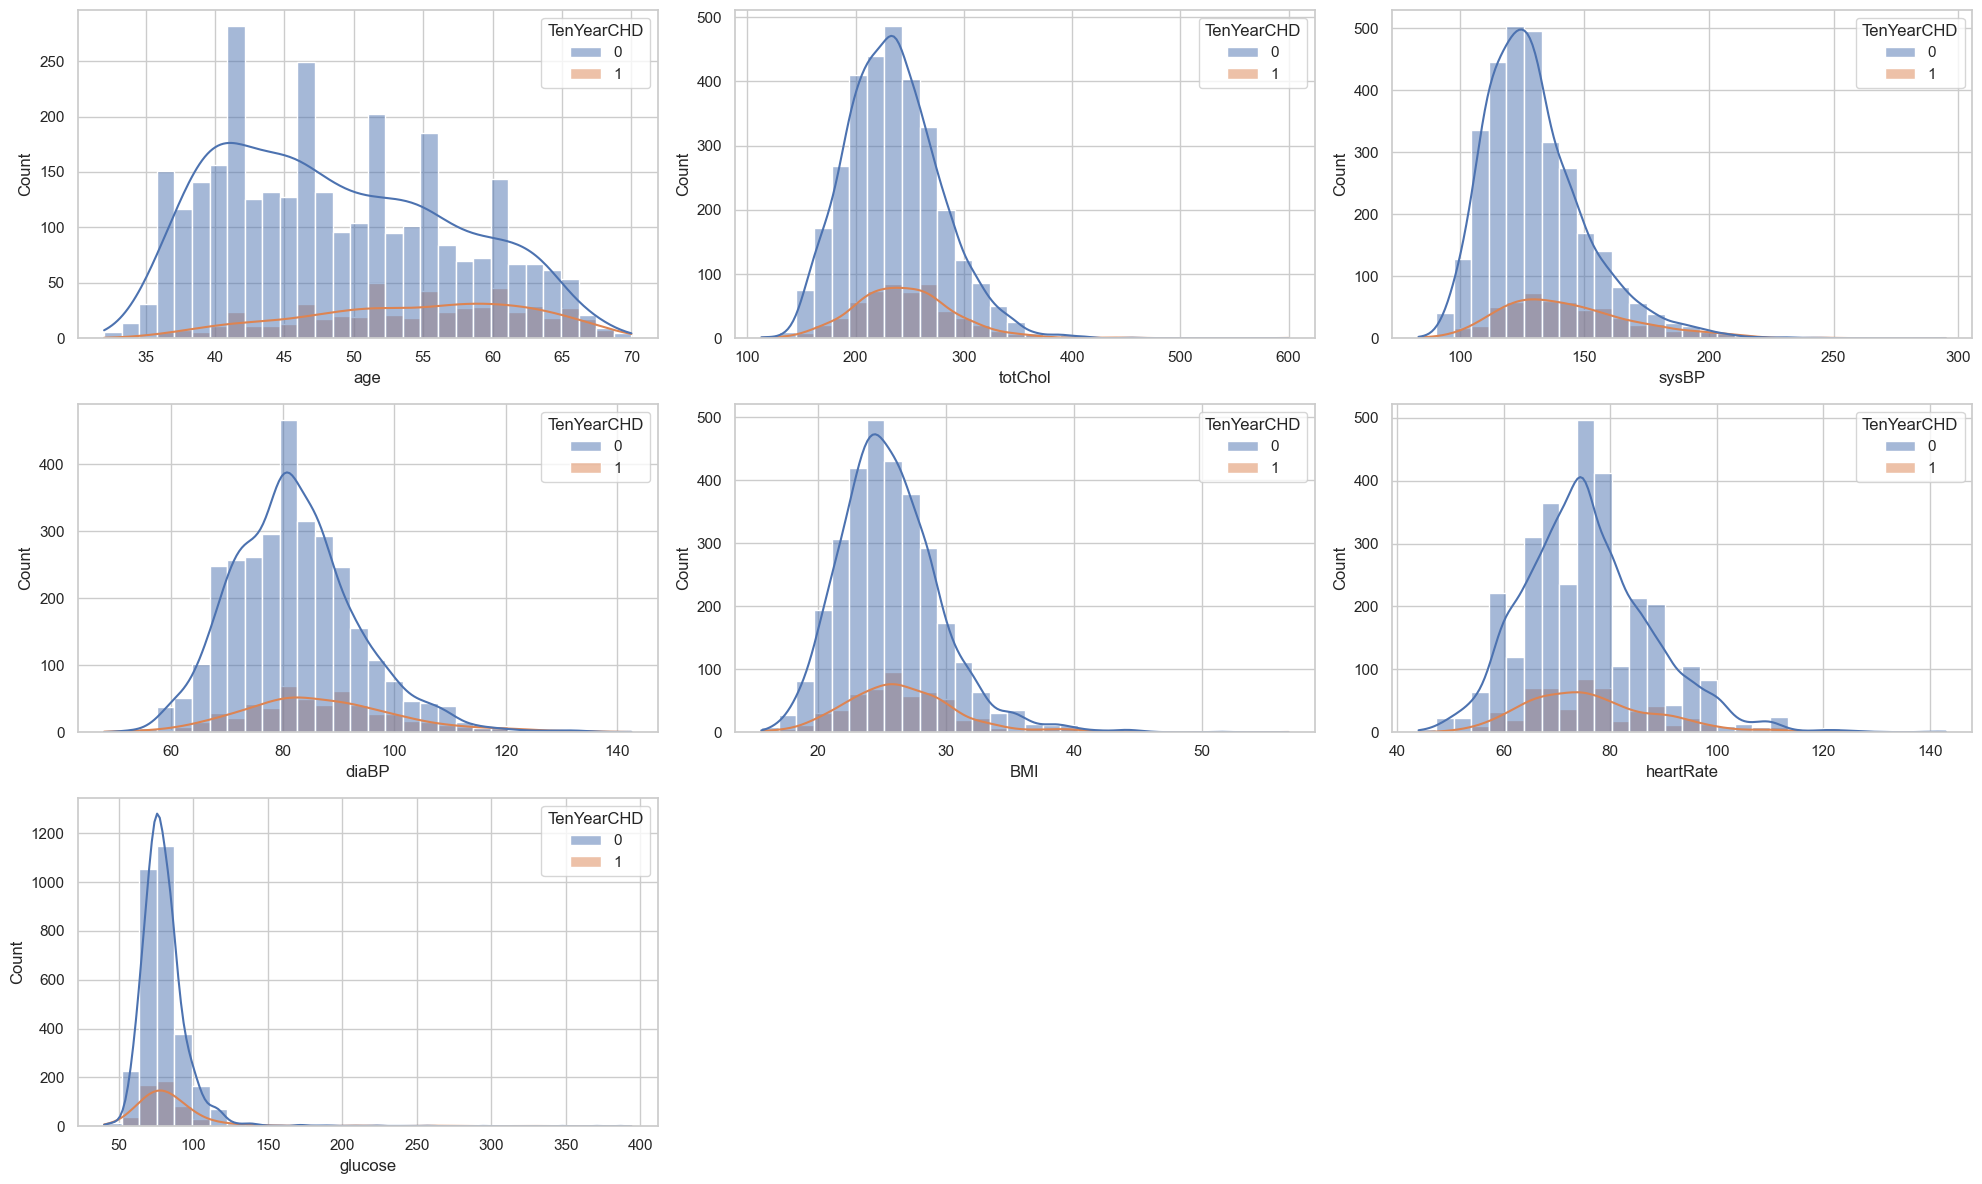

In [38]:
# distribution of all data
features = df[['age','totChol','sysBP','diaBP','BMI','heartRate','glucose']]
col = 3
row = int(len(features.columns)/col) + 1
plt.figure(figsize=(20,12))

for id, features in enumerate(features.columns, 1):
    plt.subplot(row, col, id)
    sns.histplot(data=df, x=features, hue='TenYearCHD', bins=30, kde=True)
    #plt.title(features)

plt.tight_layout()
plt.show()

#### there are some outliers in the data.
#### It's good to train the model with some outliers to avoid overfitting

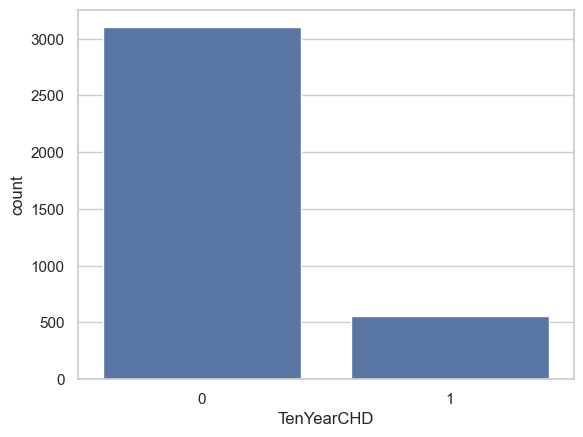

In [35]:
sns.countplot(data=df, x='TenYearCHD')
plt.show()

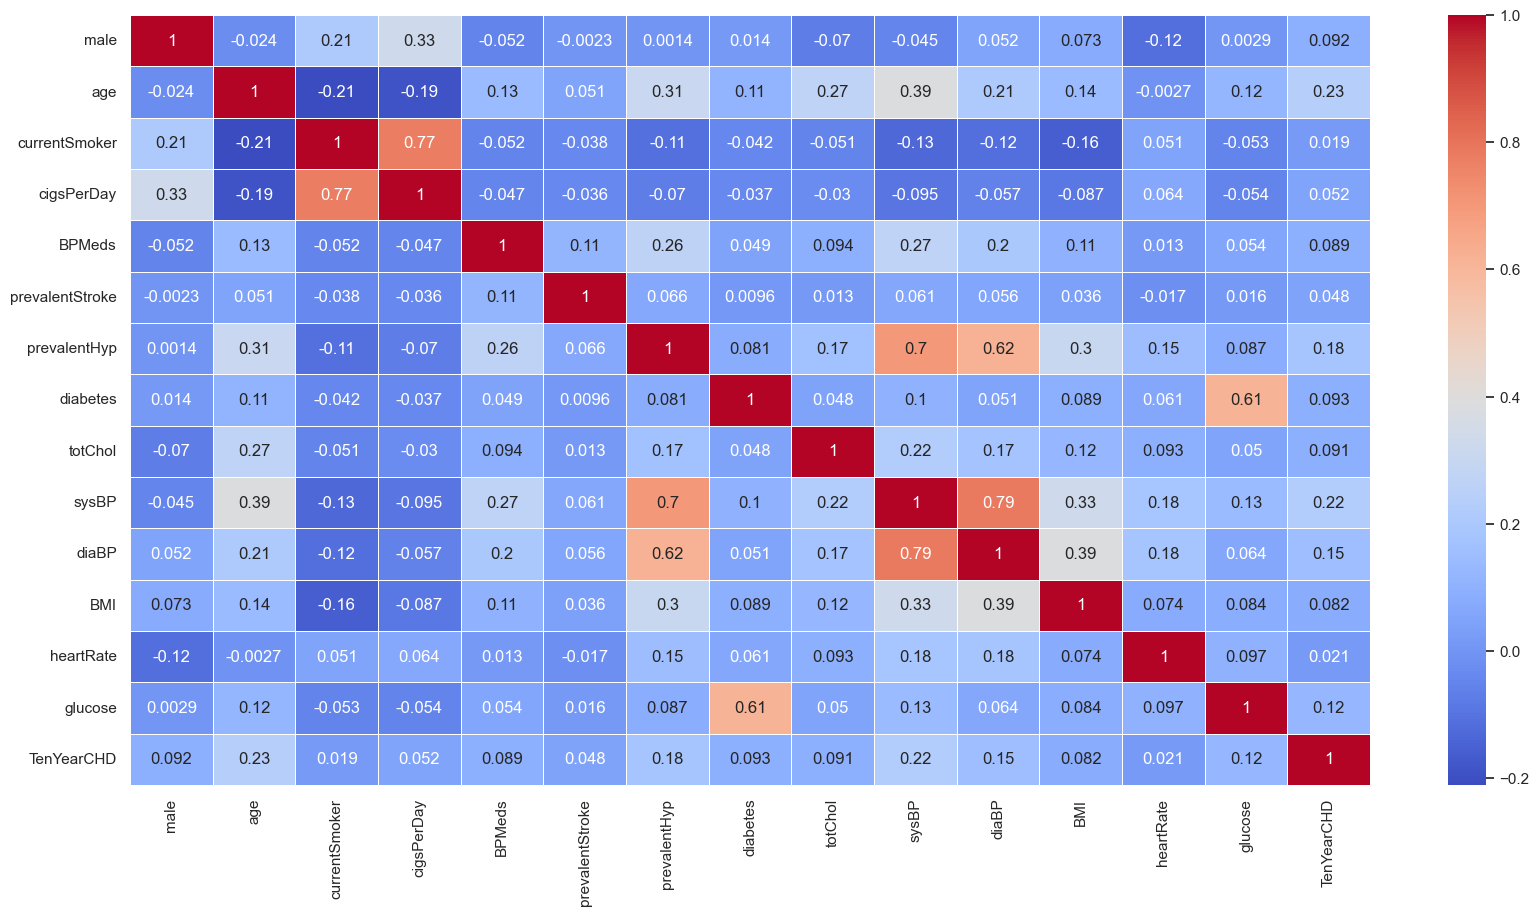

In [37]:
# correlation between different features
plt.figure(figsize=(20,10))
sns.heatmap(data=df.corr(), cmap='coolwarm', annot=True, linewidths=0.7)
plt.show()

In [40]:
# extract features and target

X = df.iloc[:,:-1]
y = df['TenYearCHD']

In [41]:
# Scaling

preprocessing = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), X.columns.tolist())
])

In [42]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [57]:
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
models = {
    "LR" : {
        "model":LogisticRegression(class_weight='balanced'),
        "params":{
            "classifier__solver": ["liblinear", "saga"],
            "classifier__max_iter": [100, 500, 1000]
        }
    },

    "DTree":{
        "model":DecisionTreeClassifier(random_state=42,),
        "params":{
            "classifier__max_depth":[2,3,4,5],
            "classifier__max_leaf_nodes":[3,4,5,6]
        }
    },

    "RFT":{
        "model":RandomForestClassifier(class_weight='balanced'),
        "params":{
            "classifier__n_estimators": [100, 200, 500],
            "classifier__max_depth": [None, 5, 10, 20],
            "classifier__class_weight": [None, "balanced", "balanced_subsample"]
        }
    },

    "xgboost":{
        "model":xgb.XGBClassifier(),
        "params":{
           "classifier__n_estimators": [100, 200, 500],
            "classifier__max_depth": [3, 5, 7, 10],
            "classifier__scale_pos_weight": [1, ratio, ratio/2, ratio*2]
                }
    }
}

In [47]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Heart_Classifier")

2025/08/13 01:09:36 INFO mlflow.tracking.fluent: Experiment with name 'Heart_Classifier' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/102518999767966035', creation_time=1755027576183, experiment_id='102518999767966035', last_update_time=1755027576183, lifecycle_stage='active', name='Heart_Classifier', tags={}>

In [64]:
best_overall_model_ = None
best_accuracy = 0
best_name = None

for name, model_df in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor",preprocessing),
        ("classifier", model_df["model"])
    ])

    grid = GridSearchCV(pipeline, model_df["params"], cv=5)
    grid.fit(X_train, y_train)

    model = grid.best_estimator_
    y_pred = model.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    cl_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    print("++++++++++ models ++++++++++++++")
    print("\nModel Name", name)
    print("accuracy score", acc_score)
    print("classification report \n", report)

    with mlflow.start_run(run_name=name):
        mlflow.log_params(grid.best_params_)
    
        mlflow.log_metric("accuracy", acc_score)
        mlflow.log_metric("Precision", cl_report['macro avg']['precision'])
        mlflow.log_metric("recall", cl_report['macro avg']['recall'])
        mlflow.log_metric("f1-score", cl_report['macro avg']['f1-score'])
    
        mlflow.sklearn.log_model(model, name="model")

    if acc_score > best_accuracy:
        best_accuracy = acc_score
        best_overall_model_ = model
        best_name = name

# Results
print(f"\nBest Model Accuracy: {acc_score:.4f}")
print(f"Best Model Name: {name}")
print("Best Parameters:", grid.best_params_)
        
    # Save best model locally

print("\n************* best model **************")
print("best model to be saved", best_overall_model_)
joblib.dump(best_overall_model_, "BestBreastCancerModel.pkl")
print("\nBest model saved as BestBreastCancerModel.pkl")
    

++++++++++ models ++++++++++++++

Model Name LR
accuracy score 0.6885245901639344
classification report 
               precision    recall  f1-score   support

           0       0.93      0.69      0.79       776
           1       0.29      0.70      0.41       139

    accuracy                           0.69       915
   macro avg       0.61      0.69      0.60       915
weighted avg       0.83      0.69      0.73       915



2025/08/13 02:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LR at: http://localhost:5000/#/experiments/102518999767966035/runs/5065372e77d7462e95a5248f3d3ab21e
🧪 View experiment at: http://localhost:5000/#/experiments/102518999767966035
++++++++++ models ++++++++++++++

Model Name DTree
accuracy score 0.848087431693989
classification report 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       776
           1       0.00      0.00      0.00       139

    accuracy                           0.85       915
   macro avg       0.42      0.50      0.46       915
weighted avg       0.72      0.85      0.78       915



2025/08/13 02:37:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DTree at: http://localhost:5000/#/experiments/102518999767966035/runs/60d106d58f67417784b9ed100d111ff5
🧪 View experiment at: http://localhost:5000/#/experiments/102518999767966035
++++++++++ models ++++++++++++++

Model Name RFT
accuracy score 0.8502732240437159
classification report 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       776
           1       0.67      0.03      0.06       139

    accuracy                           0.85       915
   macro avg       0.76      0.51      0.49       915
weighted avg       0.82      0.85      0.79       915



2025/08/13 02:42:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RFT at: http://localhost:5000/#/experiments/102518999767966035/runs/dcff74ecc2de4cf8a0e7c9442621def1
🧪 View experiment at: http://localhost:5000/#/experiments/102518999767966035
++++++++++ models ++++++++++++++

Model Name xgboost
accuracy score 0.8382513661202186
classification report 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       776
           1       0.40      0.12      0.19       139

    accuracy                           0.84       915
   macro avg       0.63      0.54      0.55       915
weighted avg       0.79      0.84      0.80       915



2025/08/13 02:43:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgboost at: http://localhost:5000/#/experiments/102518999767966035/runs/3a27df0221b040009b7885b23e7e1fd0
🧪 View experiment at: http://localhost:5000/#/experiments/102518999767966035

Best Model Accuracy: 0.8383
Best Model Name: xgboost
Best Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 1}

************* best model **************
best model to be saved Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['male', 'age',
                                                   'currentSmoker',
                                                   'cigsPerDay', 'BPMeds',
                                                   'prevalentStroke',
                                                   'prevalentHyp', 'diabetes',
                                                   'totChol', 'sysBP', 'diaBP',
                          